# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
Description here

## Import Packages

In [1]:
#importing some useful packages
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Load test images
Our first step is to load and visualize the test images.

In [2]:
test_img_dir = 'test_images/'
test_img_names = os.listdir(test_img_dir)
test_img_names = [test_img_dir + name for name in test_img_names]
test_img_names 

['test_images/solidYellowCurve.jpg',
 'test_images/solidYellowLeft.jpg',
 'test_images/solidYellowCurve2.jpg',
 'test_images/solidWhiteRight.jpg',
 'test_images/whiteCarLaneSwitch.jpg',
 'test_images/solidWhiteCurve.jpg']

In [3]:
test_imgs = [mpimg.imread(name) for name in test_img_names]

In [4]:
def show_test_images(test_imgs=test_imgs, test_img_names=test_img_names, cols=2, figsize=(10, 10)):
    img_count = len(test_imgs)
    rows = np.ceil(img_count / cols)
    cmap = None
    
    plt.figure(figsize=figsize)
    
    for idx, img in enumerate(test_imgs):
        img_name = test_img_names[idx]
        plt.subplot(rows, cols, idx+1)
        if len(img.shape) <3:
            cmap='gray'
        
        plt.title(img_name.split('/')[1])
        plt.imshow(img, cmap=cmap)
        
    plt.tight_layout()
    plt.show()
    
    

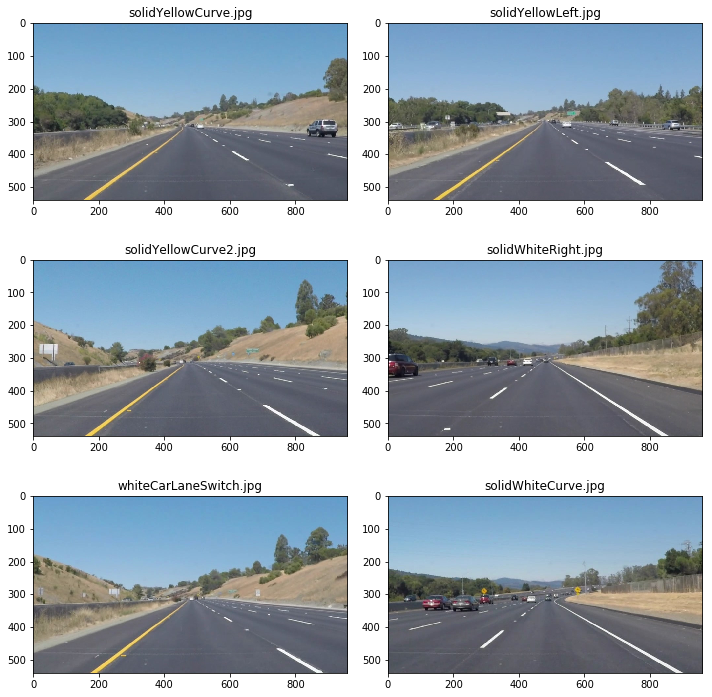

In [5]:
show_test_images()

## Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Pipeline
The pipeline for detecting lane lines consists of the following steps:
* Select region of interest
* Color masking: Detect yellow and white
* Convert image to grayscale
* Gaussian blurring
* Canny edge detection
* Hough transform
* Separate left and right lines
* Average them to one left and one right lane
* Extrapolate two continuous lanes 

## Helper Functions

In [58]:
def region_of_interest(img):
    """Implementation of region of interest selection as seen in the lectures"""
    # Perform a linear fit (y=Ax+B) to each of the three sides of the triangle
    # np.polyfit returns the coefficients [A, B] of the fit
    ysize = img.shape[0]
    xsize = img.shape[1]
    
    left_bottom = [80, ysize]
    right_bottom = [xsize - 50, ysize]
    apex = [int(xsize/2), int(ysize/2)]
    
    fit_left = np.polyfit((left_bottom[0], apex[0]), (left_bottom[1], apex[1]), 1)
    fit_right = np.polyfit((right_bottom[0], apex[0]), (right_bottom[1], apex[1]), 1)
    fit_bottom = np.polyfit((left_bottom[0], right_bottom[0]), (left_bottom[1], right_bottom[1]), 1)

    # Find the region inside the lines
    XX, YY = np.meshgrid(np.arange(0, xsize), np.arange(0, ysize))
    region_thresholds = (YY > (XX*fit_left[0] + fit_left[1])) & \
                        (YY > (XX*fit_right[0] + fit_right[1])) & \
                        (YY < (XX*fit_bottom[0] + fit_bottom[1]))
    
    # Mask region selection
    image = np.copy(img)
    # write if else depending on number of color channels e.g. [0, 0, 0] for three channesl
    image[~region_thresholds] = 0
    return image

def to_hls(img):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    return hls

def get_white_stuff_rgb(img):
    low_threshold = np.array([220, 220, 220], dtype=np.uint8)
    high_threshold = np.array([255, 255, 255], dtype=np.uint8)
    white_mask = cv2.inRange(img, low_threshold, high_threshold)
    return white_mask

def get_yellow_stuff(img):
    img = to_hls(img)
    low_threshold = np.array([20, 100, 100], dtype=np.uint8)
    high_threshold = np.array([30, 255, 255], dtype=np.uint8)
    yellow_mask = cv2.inRange(img, low_threshold, high_threshold)
    return yellow_mask

def color_select(img):
    yellow_mask = get_yellow_stuff(img)
    white_mask = get_white_stuff_rgb(img)
    mask = cv2.bitwise_or(yellow_mask, white_mask)
    return cv2.bitwise_and(img, img, mask=mask)

def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def gaussian_blur(img, kernel_size=5):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(image=img, threshold1=50, threshold2=150)

def hough_transform(img, rho=1, theta=np.pi/180, threshold=15, min_line_len=25, max_line_gap=10):
    """
    `img` should be the output of a Canny transform.
        
    Returns the hough lines obtained by the hough transform
    """
    hough_lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, 
                            maxLineGap=max_line_gap)
    return hough_lines

def get_hough_image(canny_img, hough_lines):
    """Helper function for plotting the hough lines. Creates a black image with the hough lines 
    displayed in red in it. Image has same shape as initial image."""
    # do I need a copy here?
    blank_img = np.zeros((canny_img.shape[0], canny_img.shape[1], 3), dtype=np.uint8)
    hough_img = draw_lines(blank_img, hough_lines)
    return hough_img


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """will get overwritten below"""
    
   # copying is necessary because Python is pass-by-reference
    img_copy = np.copy(img)
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(img_copy, (x1, y1), (x2, y2), color, thickness)
    return img_copy

                
# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test the Pipeline

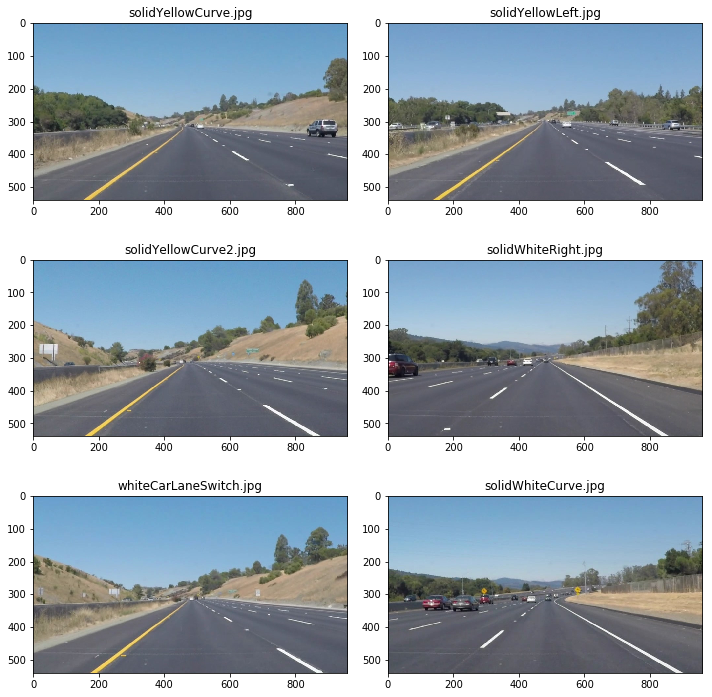

In [46]:
test_imgs = [im for im in test_imgs]
show_test_images(test_imgs)

### HSL color space
It is quite tricky to get color thresholds for yellow in the RGB space. Therefore, we switch into HSV color space to isolate yellow objects from the image. The advantage of this transformation is 

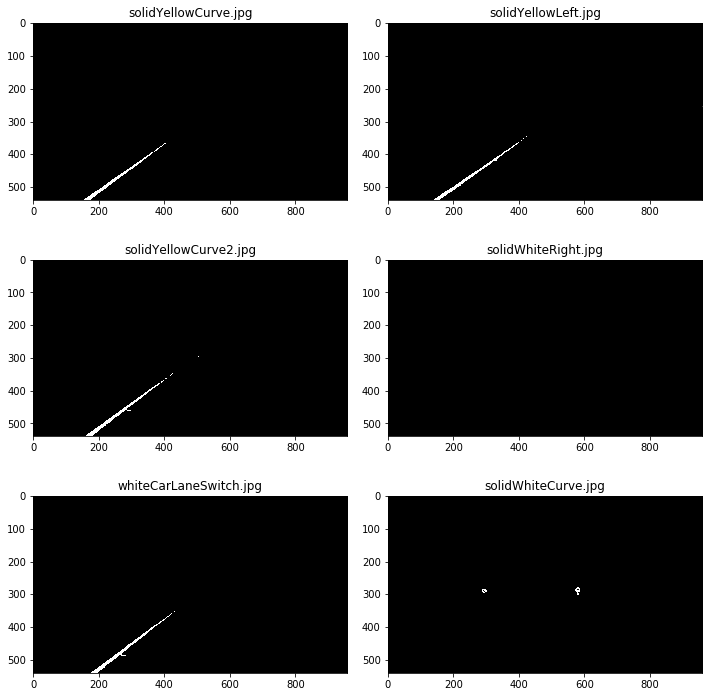

In [28]:
yellow_imgs = [get_yellow_stuff(img) for img in test_imgs]
    
show_test_images(yellow_imgs)
    

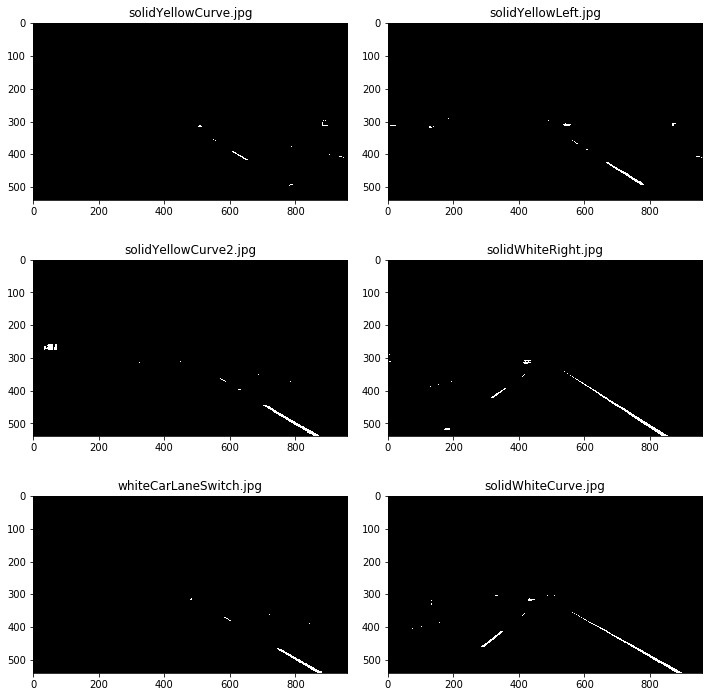

In [29]:
white_sel_imgs = [get_white_stuff_rgb(img) for img in test_imgs]
show_test_images(white_sel_imgs)

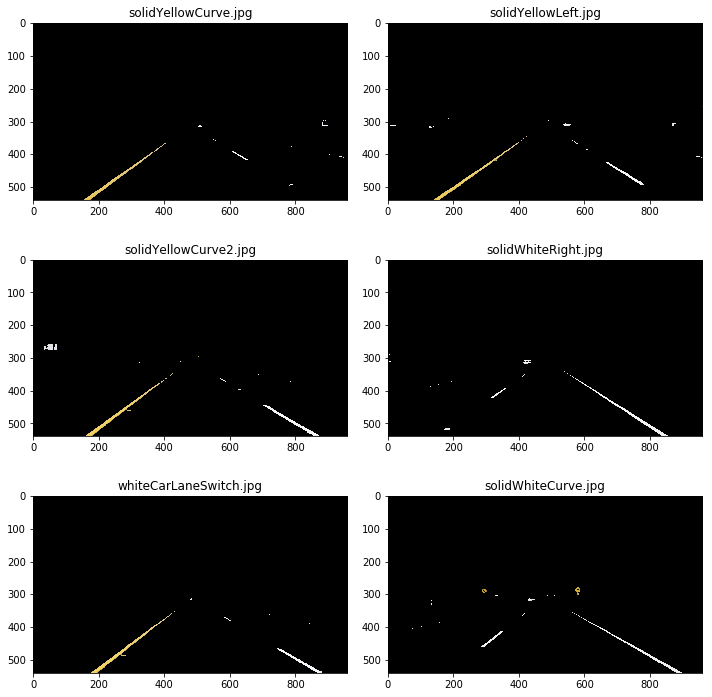

In [30]:
color_sel = [color_select(img) for img in test_imgs]
show_test_images(color_sel)

This looks good. Now we convert to grayscale.

### Grayscale


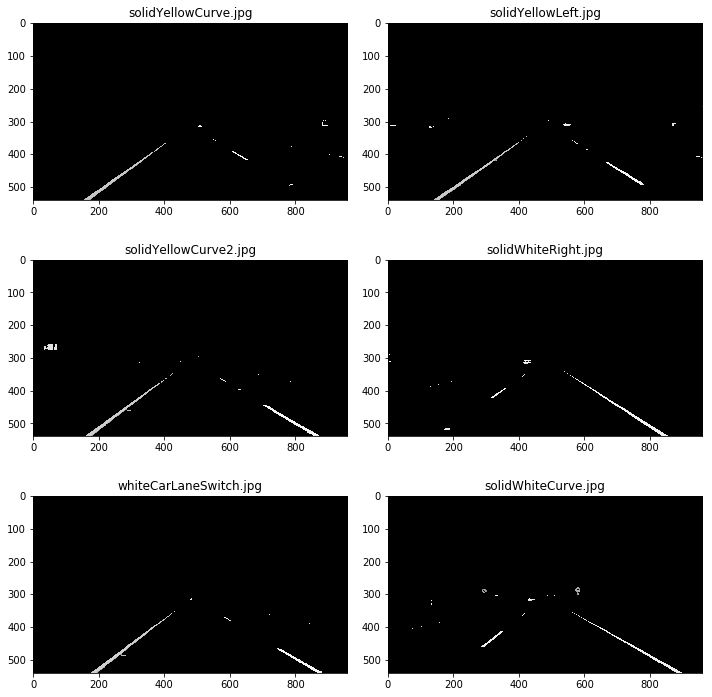

In [31]:
gray_imgs = [grayscale(img) for img in color_sel]
show_test_images(gray_imgs)

This looks pretty good. Maybe we need a bit more space on the right. Next, we try select the relevant region around the lines. 

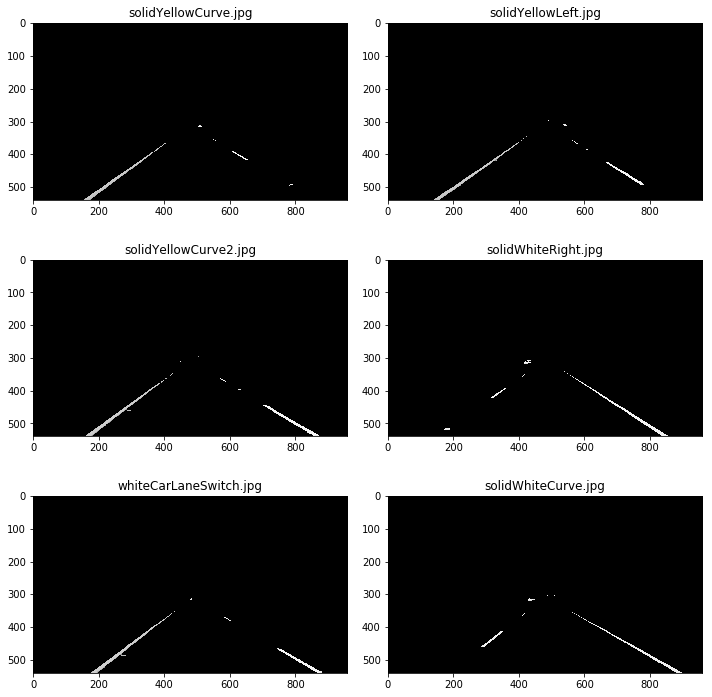

In [32]:
region_sel = [region_of_interest(img) for img in gray_imgs]
show_test_images(region_sel)

This seems to be working. Maybe be a little more generous with the region selection.

As an alternative, we try also the pre-defined version for region selection. 

### Gaussian Blur


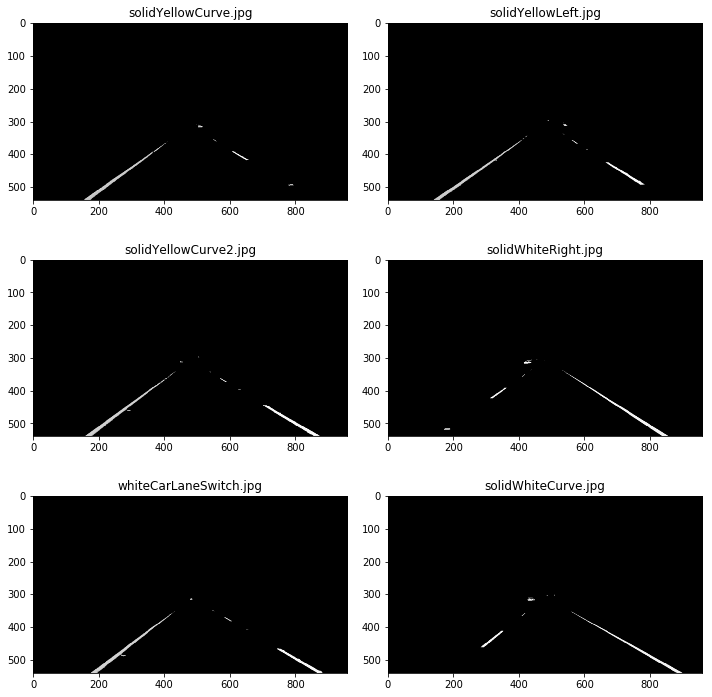

In [33]:
gaussian_imgs = [gaussian_blur(img, kernel_size=3) for img in region_sel]
show_test_images(gaussian_imgs)

### Canny Edge Detection
Next, we apply Canny edge detection. This method has the parameters `low_threshold` and `high_threshold`. Values greater than the high threshold are included in an edge, while values between low_threshold and high_threshold are only included, if they are next to an edge pixel. Usually, the ration between low_threshold and high_threshold should be 1:2 or 1:3.

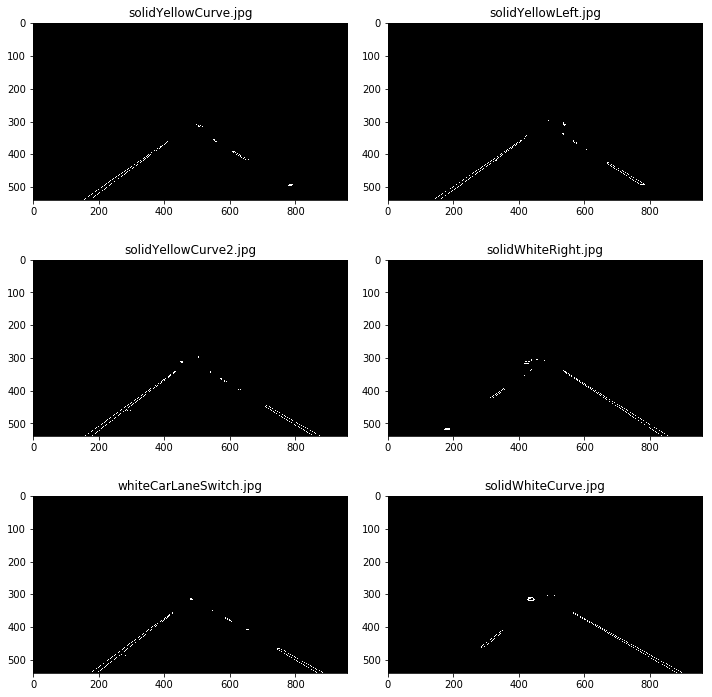

In [34]:
canny_imgs = [canny(img, low_threshold=50, high_threshold=150) for img in gaussian_imgs]
show_test_images(canny_imgs)

### Hough Transformation
Next, hough transformation interpolates lines from the detected edges. Parameters are: `rho`, `theta`, `threshold`, `min_line_len`, `max_line_gap`. We start with the following values:
* rho = 1
* theta = np.pi/180
* threshold = 1
* min_line_length = 10
* max_line_gap = 1

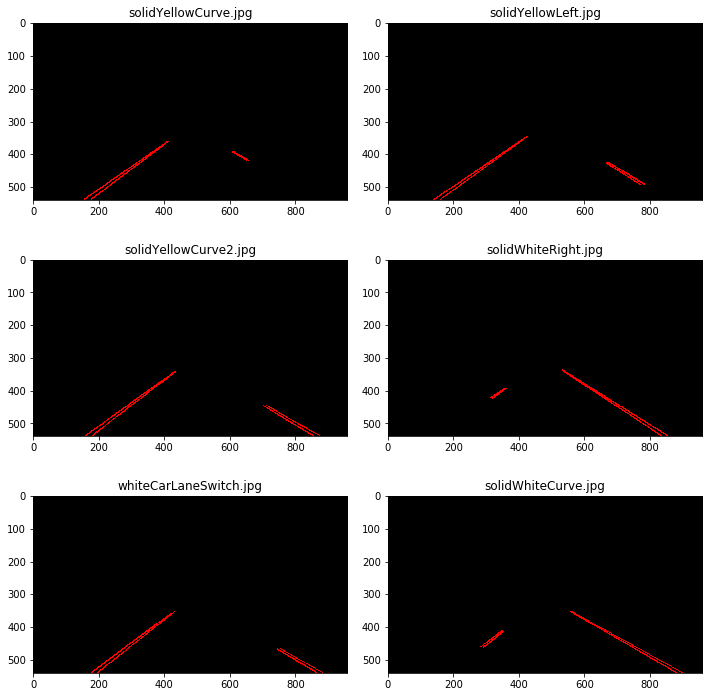

In [51]:
hough_trafos = [hough_transform(img, threshold=15, min_line_len=25, max_line_gap=10) for img in canny_imgs]
hough_imgs = [get_hough_image(img, hough_trafo) for (img, hough_trafo) in zip(canny_imgs, hough_trafos)]
show_test_images(hough_imgs)

We see that the parameters `min_line_len=25` and `max_line_gap=10` work reasonably well. The separate_lanes algorithm works perfectly.

### Creating a Pipeline
Now it's time to create a pipeline function that combines the above steps.

In [52]:
def detect_lane_lines_without_lane_interpolation(img):
    # color selection
    color_img = color_select(img)
    # grayscaling
    gray_img = grayscale(color_img)
    # region selection
    region_img = region_of_interest(gray_img)
    # gaussian blur
    gaussian_img = gaussian_blur(region_img)
    # canny edge detection
    canny_img = canny(gaussian_img, low_threshold=50, high_threshold=150)
    # hough transform
    hough_trafo = hough_transform(canny_img, min_line_len=25, max_line_gap=10)
    ##############################################
    # here is going to be the draw_lanes function
    #############################################
    # draw lines on image
    hough_img = get_hough_image(canny_img, hough_trafo)
    weighted_image = weighted_img(img=hough_img, initial_img=img)
    return weighted_image


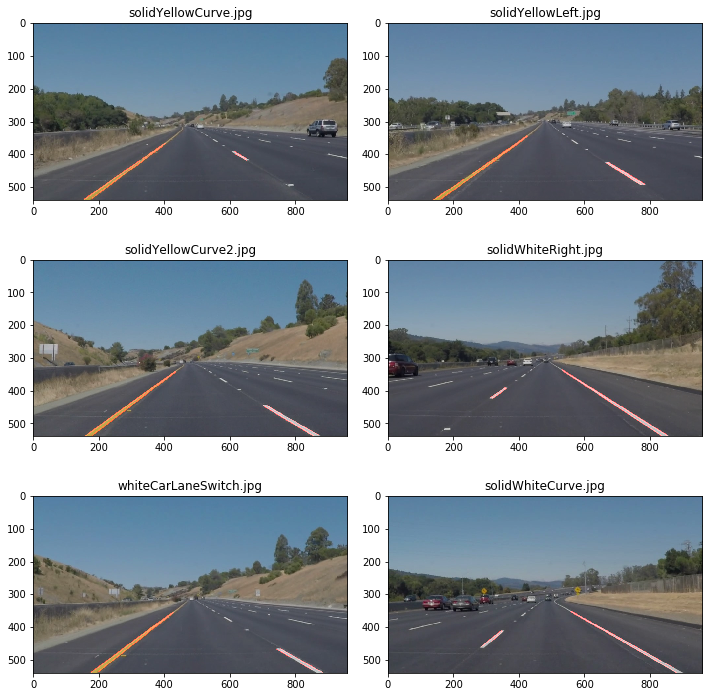

In [53]:
analyzed_imgs = [detect_lane_lines_without_lane_interpolation(img) for img in test_imgs]
show_test_images(analyzed_imgs)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [54]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Let's try the one with the solid white lane on the right first ...

In [55]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(detect_lane_lines_without_lane_interpolation) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:04<00:00, 42.01it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 4.5 s, sys: 1.28 s, total: 5.78 s
Wall time: 5.22 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [56]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**
### Separate left and right lanes
Our goal is to interpolate one line for the left lane line and one line for the right lane line. Therefore, we separate all left hough lines from all right hough lines. If a lines has positive slope, it is a left line. If a line has negative slope, it is a right line. We redefine our draw_lanes function:

In [75]:
def draw_lanes_different_color(img, left_lanes, right_lanes, left_lane_color=[255, 0, 0], right_lane_color=[0, 0, 255], 
                               thickness=4):
    """colors the left lane lines red and the right lane lines blue and adds them both to `img`."""
    left_lane_image=draw_lines(img, left_lanes, left_lane_color, thickness)
    right_left_lane_image=draw_lines(left_lane_image, right_lanes, right_lane_color, thickness)
    ### here is something missing. We want both lanes be drawn on the same image!!
    return right_left_lane_image

def separate_lanes(img, lines):
    left_lanes = []
    right_lanes = []
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            delta_x = x2 - x1
            # discard lines delta_x == 0 or delta_y == 0 because slope can't be computed or
            # lines can not be identified as left or right
            if(delta_x == 0): 
                continue
            delta_y = y2 - y1
            if (delta_y == 0):
                continue
            
            slope = delta_y / delta_x
            
            # discard horizontal lines, i.e. lines with small slope
            horizontal_threshold = 0.1
            if abs(slope) < horizontal_threshold:
                continue
            
            # This is pure guess than anything... 
            # but get rid of lines with a small slope as they are likely to be horizontal one
            
            middle_x = img.shape[1] / 2
            epsilon = 0.1
            if abs(slope) <= epsilon:
                continue
            
            if slope < 0 and x1 < middle_x and x2 < middle_x:
                # Lane should also be within the left hand side of region of interest
                left_lanes.append([[x1, y1, x2, y2]])
            elif x1 >= middle_x and x2 >= middle_x:
                # Lane should also be within the right hand side of region of interest
                right_lanes.append([[x1, y1, x2, y2]])
                
    return left_lanes, right_lanes
    

### We test the separation of left and right lines by coloring them differently. 
We test the above functions again with our test images.

left: 6, right: 4
left: 7, right: 7
left: 9, right: 5
left: 3, right: 7
left: 11, right: 5
left: 4, right: 7


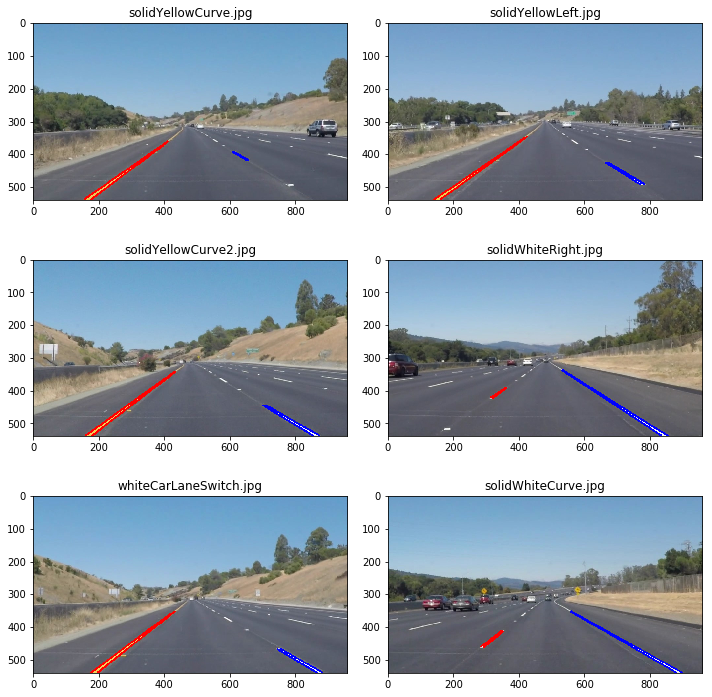

In [76]:
separated_imgs= []
for (im, h_trafo) in zip(test_imgs, hough_trafos):
    left_lanes, right_lanes = separate_lanes(im, h_trafo)
    print("left: %d, right: %d"% (len(left_lanes), len(right_lanes)))
    lane_image = draw_lanes_different_color(im, left_lanes=left_lanes, right_lanes=right_lanes)
    separated_imgs.append(lane_image)

show_test_images(separated_imgs)

The new draw_lanes() function separates left from right lines perfectly and colors them differently. In the next step we combine the left lines and right lines to one left and one right lane line each.

## Lane extrapolation.
Now, it's our task to combine the various left and right lines to one line that starts at the bottom of the image and extends until the end of the region of interest. To achieve this, we run a linear regression, which finds a line that fits the points on the different lanes as well as possible (with least mean square error).

In [121]:
from scipy import stats

def get_lane_parameters(lines):
    """This algorithm gets the slope and intercept of an average line between the hough lines by linear regression.
    This algorithm works just fine."""
    x_values = []
    y_values = []
    for line in lines:
        for x1, y1, x2, y2 in line:
            x_values.append(x1)
            y_values.append(y1)
            x_values.append(x2)
            y_values.append(y2)
    # We choose the top y value as the minimum value over the y values of all lines.
    top_y = min(y_values)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_values, y_values)
    return (slope, intercept, top_y)

    
def get_full_lane(img, lines):
    # first, one average line is created out of lines by linear regression
    slope, intercept, top_y = get_lane_parameters(lines)
    bottom_y = img.shape[0] - 1
    
    bottom_x = (bottom_y - intercept) / slope
    top_x = (top_y - intercept) / slope
    full_lane = [[[int(bottom_x), int(bottom_y), int(top_x), int(top_y)]]]
    return full_lane
    

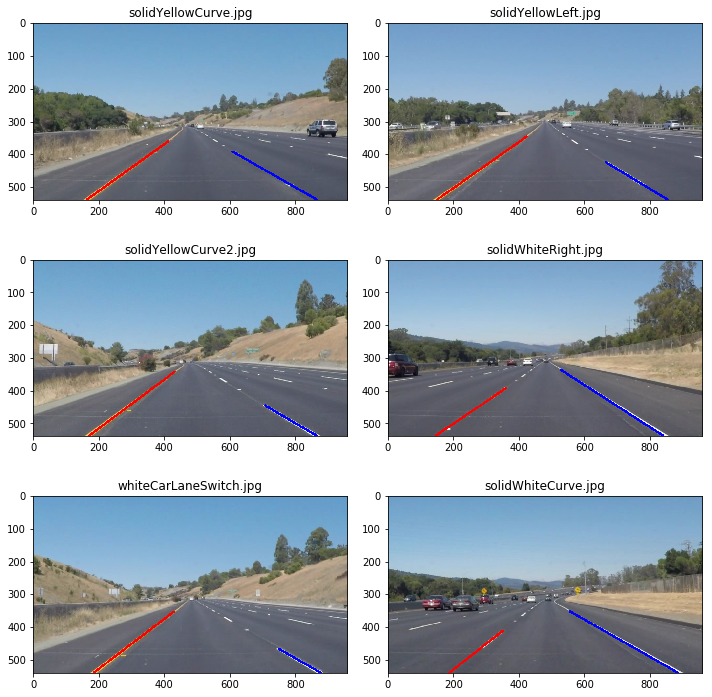

In [122]:
lane_images = []
for (im, h_trafo) in zip(test_imgs, hough_trafos):
    left_lanes, right_lanes = separate_lanes(im, h_trafo)
    full_lane_left = get_full_lane(im, left_lanes)
    full_lane_right = get_full_lane(im, right_lanes)
    lane_image = draw_lanes_different_color(im, full_lane_left, full_lane_right, thickness=5)
    lane_images.append(lane_image)
show_test_images(lane_images)

Use a thicker line!
top value works fine. Lines are not always correct. Only solid lines work well. 
--> check algorithm. Maybe use something else instead of linear regression.

Question: Do we need the weighted_image algorithm here or is `draw_lanes_different_color` enough?

In [24]:
def detect_lane_lines_with_lane_interpolation(img):
    # color selection
    color_img = color_select(img)
    # grayscaling
    gray_img = grayscale(color_img)
    # region selection
    region_img = region_of_interest(gray_img)
    # gaussian blur
    gaussian_img = gaussian_blur(region_img)
    # canny edge detection
    canny_img = canny(gaussian_img, low_threshold=50, high_threshold=150)
    # hough transform
    hough_trafo = hough_transform(canny_img, min_line_len=25, max_line_gap=10)
    ### maybe rather do one interpolation function
    # separate left from right lanes
    left_lanes, right_lanes = separate_lanes()
    ##############################################
    # here is going to be the draw_lanes function
    #############################################
    # draw lines on image
    weighted_image = weighted_img(img=hough_img, initial_img=img)
    return weighted_image

# Test Pipeline on Video Files

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [25]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Let's try the one with the solid white lane on the right first ...

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [26]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(detect_lane_lines)
%time yellow_clip.write_videofile(yellow_output, audio=False)

NameError: name 'detect_lane_lines' is not defined

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.
